In [5]:
# pyrates imports
from pyrates.ir.circuit import CircuitIR
from pyrates.backend import ComputeGraph
from pyrates.utility import plot_connectivity
from pyrates.frontend import CircuitTemplate

# additional imports
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sb
from copy import deepcopy

In [2]:
# parameter definitions
dt = 1e-3
T = 10.0
c = 20.
n_jrcs =[1, 10, 20, 30, 40]
p_conn = [0.81, 0.27, 0.09, 0.03, 0.01]
sim_times = np.zeros((len(n_jrcs), len(p_conn), 4))

In [ ]:
def benchmark(Ns, Ps, T, dt, init_kwargs, run_kwargs):
    """

    Parameters
    ----------
    Ns
    Ps
    T
    dt
    init_kwargs
    run_kwargs

    Returns
    -------

    """

    times = np.zeros((len(Ns), len(Ps)))
    peak_mem = np.zeros_like(times)

    for i, n in enumerate(Ns):
        for j, p in enumerate(Ps):

            # define inter-JRC connectivity
            C = np.random.uniform(size=(n, n))
            C[C > p] = 0.
            conns = DataFrame(C, columns=[f'jrc_{idx}/PC.0/PRO.0/m_out' for idx in range(n)])
            conns.index = [f'jrc_{idx}/PC.0/RPO_e_pc.0/m_in' for idx in range(n)]

            # define input
            inp = 220 + np.random.randn(int(T / dt), n) * 22.

            # set up networks
            template = CircuitTemplate.from_yaml("pyrates.examples.jansen_rit.simple_jr.JRC")
            circuits = {}
            for idx in range(n):
                circuits[f'jrc_{idx}'] = deepcopy(template)
            circuit = CircuitIR.from_circuits(label='net', circuits=circuits, connectivity=conns)
            net = ComputeGraph(circuit, dt=dt, **init_kwargs)

            # run simulations
            _, t, m = net.run(T, inputs={('PC', 'RPO_e_pc.0', 'u'): inp}, outputs={'V': ('PC', 'PRO.0', 'PSP')},
                              verbose=False, **run_kwargs)
            times[i, j] = t
            peak_mem[i, j] = m

    return times, peak_mem

In [3]:
# pyrates simulation
t, _ = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'nodes'}, run_kwargs={'profile': 't'})
sim_times[:, :, 0] = t
t, _ = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'full'}, run_kwargs={'profile': 't'})
sim_times[:, :, 1] = t
_, m = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'nodes'}, run_kwargs={'profile': 'm'})
sim_times[:, :, 2] = m
_, m = benchmark(n_jrcs, p_conn, T, dt, init_kwargs={'vectorization': 'full'}, run_kwargs={'profile': 'm'})
sim_times[:, :, 3] = m

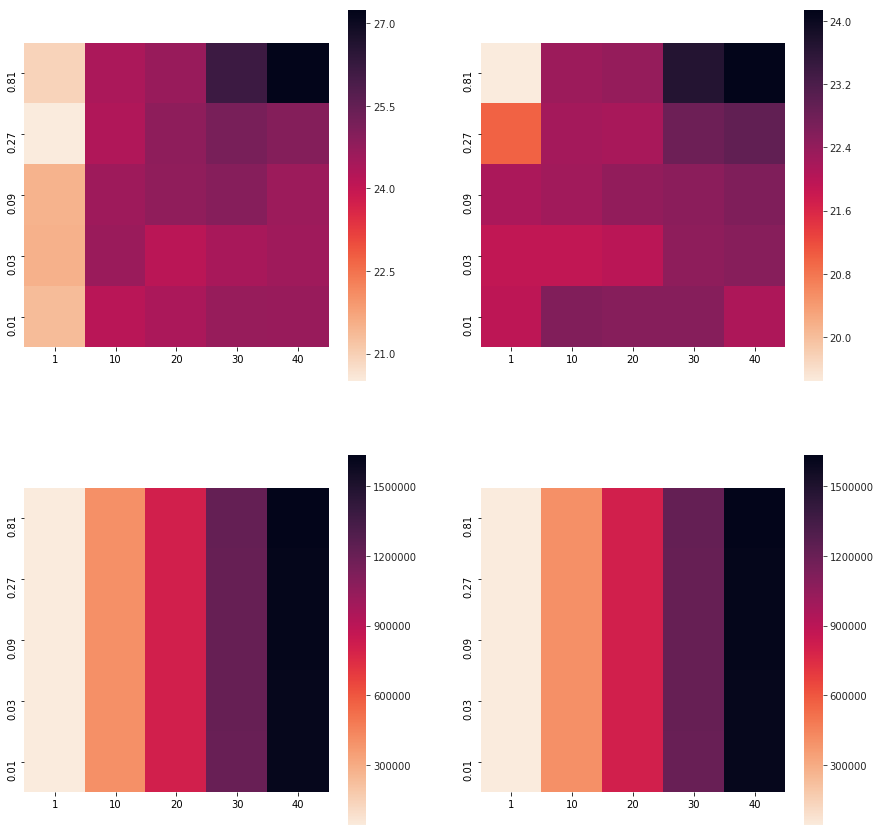

In [6]:
# plotting
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
cm1 = cubehelix_palette(n_colors=int(len(n_jrcs)**2), as_cmap=True, start=2.5, rot=-0.1)
cm2 = cubehelix_palette(n_colors=int(len(n_jrcs)**2), as_cmap=True, start=-2.0, rot=-0.1)
axes[0, 0].set_aspect(1.0)
axes[0, 1].set_aspect(1.0)
axes[1, 0].set_aspect(1.0)
axes[1, 1].set_aspect(1.0)
plot_connectivity(sim_times[:, :, 0], ax=axes[0, 0], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm1)
plot_connectivity(sim_times[:, :, 1], ax=axes[0, 1], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm1)
plot_connectivity(sim_times[:, :, 2], ax=axes[1, 0], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm2)
plot_connectivity(sim_times[:, :, 3], ax=axes[1, 1], yticklabels=n_jrcs, xticklabels=p_conn, cmap=cm2)
plt.savefig('PyRates_benchmarks_1.svg', format='svg')
plt.show()